# 네이버 플러스 스토어 '탈모' 데이터 분석 노트북 (묶음수량/폰트 처리 포함)

입력 CSV 예상 컬럼 :
`스토어, 제목, 원래가격, 현재가격, 할인율, 상품링크, 제조사, 브랜드, 모델명, 원산지, 두피타입, 모발타입, 타입, 제품형태, 용량, 세부제품특징, 향계열, 종류, 성분, 주요제품특징` 총 20종

- 제목에 `2개/세트/x2/1+1` 등이 있으면 **묶음 수량**으로 인식하여 1개 기준 가격을 계산합니다.
- 그래프 한글 폰트 깨짐을 자동으로 방지합니다.


# 파생 컬럼 산출 로직 (원본 컬럼 기준)

### 1) 가격 관련
- **final_price (최종가격)**  
  사용 컬럼: `현재가격`(우선), 없으면 `가격`, 최후에는 `원래가격` 대체  
  공식: `final_price = 현재가격 or 가격 or 원래가격`

- **unit_count (묶음 수량)**  
  사용 컬럼: `제목`  
  규칙:  
  - 프로모션형: `1+1`, `2+1` → 두 숫자의 합 (예: 1+1→2, 2+1→3)  
  - 곱셈형: `x2`, `*3` → 뒤 숫자 그대로 (예: x2→2)  
  - 단위형: `2개`, `2세트`, `2ea`, `2개입`, `2팩`, `2입` → 숫자를 수량으로 인식  
  - 주의: `100ml`, `200g` 같은 용량 단위는 수량으로 보지 않음  
  기본값: 매칭 없으면 1

- **final_price_per_unit (1개 기준 가격)**  
  사용 컬럼: `final_price`, `unit_count`  
  공식: `final_price_per_unit = final_price ÷ unit_count`

### 2) 용량/단위가격
- **volume_ml (총 용량, ml)**  
  사용 컬럼: `용량` (비면 `제목`+설명에서 보조 추출)  
  규칙:  
  - `100ml`, `0.5L`, `200g`, `500mg` → ml로 환산 (L→×1000, mg→÷1000, g≈ml 근사)  
  - `2 x 100ml`, `100ml*2` → 곱하여 총용량(예: 2×100ml→200ml)

- **price_per_ml (ml당 가격)**  
  사용 컬럼: `final_price`, `volume_ml`  
  공식: `price_per_ml = final_price ÷ volume_ml` (총 용량 기준)

### 3) 분류/타입
- **category (카테고리 추정)**  
  사용 컬럼: `종류`, `타입`, `제품형태` (+ 보조로 `제목`/설명)  
  키워드 매칭 예: 샴푸 / 토닉 / 앰플·세럼 / 오일·트리트먼트 / 영양제(비의약품) / 기타

- **type_raw (원본 타입)**  
  사용 컬럼: `타입` (없으면 category로 대체)

### 4) 설명/키워드 플래그
- **desc**: `성분` + `주요제품특징` + `세부제품특징` 결합  
- **is_peptide / is_low_stimulus / is_clinical**: `제목`+`desc` 텍스트 키워드 매칭 → True/False  
- **ING_* 시리즈**: 성분 키워드 매칭 → 1/0

### 5) 보조
- **list_price**: `원래가격` (비면 `final_price`로 대체)  
- **discount_rate**: `할인율`(숫자화)  
- **date_parsed**(옵션): `등록일/갱신일`(있을 때) → datetime 변환


### 카테고리 채우기(4단계)
1) 원본 **`종류`** 값 사용  
2) 빈 값있으면 **`타입`**을 **`종류` 허용값**(예: *한방샴푸 → 샴푸*)으로 매핑해 채움  
3) 빈 값있으면 **`제목`**에 **허용 토큰**이 있으면 그 값으로 채움  
4) 빈 값있으면 키워드 기반 최종 분류( **토닉 / 헤어세럼 / 세럼 / 오일 / 트리트먼트 / 영양제 / 헤어기기 / 샴푸 / 샴푸바 / 기타** )


### 추가 : 피부 투과 기술 키워드
- 열 이름 : **피부 투과 기술 키워드**
- 추출 대상 : **제목**
- 키워드 : 나노, 리포좀, 스피큘, MTS, 피부 투과, 나노 리소좀, 경피 투과, DDS, 엑소좀
- 여러 키워드 동시 검출 시 `; `로 연결하여 기록


# 라이브러리

In [363]:
from pathlib import Path
import json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datetime as dt

In [364]:
# 한글 폰트 설정 함수
def setup_korean_font():
    from matplotlib import font_manager, rcParams
    candidates = ["AppleGothic","Malgun Gothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR","NanumBarunGothic"]
    available = set(f.name for f in font_manager.fontManager.ttflist)
    chosen = None
    for c in candidates:
        if c in available:
            chosen = c; break
    if chosen:
        rcParams["font.family"] = chosen
    rcParams["axes.unicode_minus"] = False
    return chosen

setup_korean_font()

'Malgun Gothic'

## 파일 경로 및 출력 폴더 설정

In [365]:
INPUT_CSV = "naver_hairloss_products_with_specs_20250929_PM114126.csv"   # 여기에 파일명 입력
OUTDIR = Path(f"out_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}")
CONFIG_JSON = None  # 예: 'config_keywords.json' (없으면 기본값 사용)

## 컬럼명변환 및 제목 구성요소 추출 세팅

In [366]:
DEFAULT_CONFIG = {
    "peptide_keywords": ["펩타이드", "peptide", "GHK", "GHK-Cu", "구리펩타이드", "copper peptide"],
    "low_stimulus_keywords": ["저자극", "무실리콘", "무향", "민감성", "무알콜", "약산성"],
    "clinical_keywords": ["임상", "피부과테스트", "더마테스트", "인체적용시험", "유효성"],
    "ingredient_keywords": [
        "미녹시딜","피나스테리드","카페인","비오틴","나이아신아마이드","덱스판테놀","징크피리치온",
        "세라마이드","징크","로즈마리","녹차","쑥","판테놀"
    ],
    "category_guess": {
        "샴푸": ["샴푸"],
        "토닉": ["토닉","스캘프 토닉","헤어토닉"],
        "앰플/세럼": ["앰플","세럼","에센스","부스터"],
        "오일/트리트먼트": ["오일","트리트먼트","팩","마스크"],
        "영양제(비의약품)": ["영양제","보충제","캡슐","정","환"]
    },
    "recent_days_for_new": 90
}

POSSIBLE_COLS = {
    "name": ["제목","상품명","제품명","title","name"],
    'manufacturer': ['제조사'],
    "brand": ["브랜드","brand"],
    "store": ["스토어","스토어명","판매처","상호","store","seller"],
    "category": ["카테고리","분류","종류","타입","제품형태","category"],
    "price": ["현재가격","할인가격","할인가","판매가격","가격","판매가","원래가격","정가","price"],
    "list_price": ["원래가격","정가"],
    "discount_price": ["현재가격","할인가격","할인가","판매가격","discount_price"],
    "discount_rate": ["할인율","할인율(%)","discount_rate"],
    "volume": ["용량","용량표기","중량","용량(g/ml)","용량(ml)","용량(g)","volume"],
    "url": ["상품링크","링크","url"],
    "desc": ["성분","주요제품특징","세부제품특징","상세요약","상세","설명","요약","description","desc","썸네일ALT","썸네일텍스트"],
    "type_raw": ["타입"],
    # "date": ["등록일","갱신일","등록/갱신","date","updated_at","created_at"],
    # "reviews": ["리뷰수","리뷰","구매평","reviews","review_count"],
    # "rating": ["평점","rating","별점"]
}

In [367]:
def ensure_dir(p: Path): 
    p.mkdir(parents=True, exist_ok=True)
    return p

def load_config(path: str | None):
    if path and Path(path).exists():
        cfg = json.loads(Path(path).read_text(encoding='utf-8'))
        merged = DEFAULT_CONFIG.copy(); merged.update(cfg); return merged
    return DEFAULT_CONFIG
def guess_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map: return lower_map[c.lower()]
    return None
def build_schema(df):
    return {k: guess_col(df, v) for k,v in POSSIBLE_COLS.items()}

## 데이터 전처리 함수

In [368]:
def to_numeric(s):
    if s is None: 
        return None
    # Convert to string, strip non-numeric, map empty/"-" to NaN, then astype(float)
    return (s.astype(str).str.replace(r"[^\d\.\-]","", regex=True)
            .replace({"": np.nan, "-": np.nan}).astype(float))

def parse_volume_to_ml(x: str):
    """Parse volumes like '2 x 100ml', '100ml*2', '500ml', '0.5L', '200g', '500mg' → ml (approx for g≈ml)."""
    if pd.isna(x): 
        return np.nan
    s = str(x).lower().replace(" ", "")
    # Case 1: quantity × value + unit (e.g., 2x100ml, 100ml*2)
    m = re.findall(r"(\d+(?:\.\d+)?)\s*(?:x|\*)\s*(\d+(?:\.\d+)?)(ml|l|g|mg)", s)
    if m:
        qty = float(m[0][0]); val = float(m[0][1]); unit = m[0][2]
        if unit in ["ml","l"]:
            per = val*(1000 if unit=="l" else 1.0)
        elif unit=="mg":
            per = val/1000.0
        else: # g
            per = val # assume 1g≈1ml for liquids
        return qty * per
    # Case 2: single value + unit
    m2 = re.findall(r"(\d+(?:\.\d+)?)(ml|l|g|mg)", s)
    if m2:
        val = float(m2[0][0]); unit = m2[0][1]
        if unit=="ml": return val
        if unit=="l": return val*1000.0
        if unit=="mg": return val/1000.0
        if unit=="g": return val
    return np.nan

def parse_pack_qty(name_text: str) -> int:
    """Infer bundle size from title text: '1+1', 'x2', '*3', '2개/2세트/2ea/2개입/2팩/2입'."""
    if not isinstance(name_text, str):
        return 1
    s = name_text.lower()
    # promo: 1+1, 2+1
    m = re.search(r'(\d+)\s*\+\s*(\d+)', s)
    if m:
        try: 
            return max(1, int(m.group(1)) + int(m.group(2)))
        except: 
            pass
    # multiplier: x2, *3
    m = re.search(r'(?:x|\*)\s*(\d+)\b', s)
    if m:
        try: 
            return max(1, int(m.group(1)))
        except: 
            pass
    # units: 2개, 2세트, 2ea, 2개입, 2팩, 2입
    cand = 1
    for g in re.findall(r'(\d+)\s*(개|세트|set|입|ea|팩)\b', s):
        cand = max(cand, int(g[0]))
    for g in re.findall(r'(\d+)(개입|세트|입|ea|팩)', s):
        cand = max(cand, int(g[0]))
    return max(1, cand)

def _stepwise_fill_category(df):
    """
    Stepwise category fill:
    1) use '종류'
    2) fill blanks by mapping '타입' into one of allowed '종류' values (e.g., 한방샴푸 → 샴푸)
    3) still blank: if '제목' contains any allowed token → use it
    4) still blank: keywords fallback among [토닉, 헤어세럼, 세럼, 오일, 트리트먼트, 영양제, 헤어기기, 샴푸, 샴푸바, 기타]
    """
    out = pd.Series([None]*len(df), index=df.index, dtype="object")
    # allowed = all non-null distinct in '종류' plus base
    allowed = set(str(v).strip() for v in df.get("종류", pd.Series(dtype=object)).dropna().unique().tolist())
    base = ["샴푸","샴푸바","토닉","헤어세럼","세럼","앰플","오일","트리트먼트","영양제","헤어기기","기타"]
    for b in base: allowed.add(b)

    # 1) 종류
    if "종류" in df.columns:
        out = df["종류"].where(df["종류"].notna() & (df["종류"].astype(str).str.strip()!=""), out)

    # helper: map 타입 → allowed
    def map_type_to_allowed(v):
        t = str(v).lower()
        if "샴푸" in t and "샴푸" in allowed: return "샴푸"
        if ("바" in t or "soap" in t or "bar" in t) and "샴푸바" in allowed: return "샴푸바"
        if ("토닉" in t or "spray" in t) and "토닉" in allowed: return "토닉"
        if ("헤어세럼" in t) and "헤어세럼" in allowed: return "헤어세럼"
        if ("세럼" in t or "ampoule" in t or "앰플" in t) and ("세럼" in allowed or "앰플" in allowed): return "세럼" if "세럼" in allowed else "앰플"
        if ("오일" in t) and "오일" in allowed: return "오일"
        if ("트리트먼트" in t or "마스크" in t or "팩" in t) and "트리트먼트" in allowed: return "트리트먼트"
        if ("영양제" in t or "캡슐" in t or "정" in t or "환" in t) and "영양제" in allowed: return "영양제"
        if ("기기" in t or "드라이어" in t or "브러시" in t) and "헤어기기" in allowed: return "헤어기기"
        return None

    # 2) 타입 매핑
    if "타입" in df.columns:
        type_map = df["타입"].apply(map_type_to_allowed)
        out = out.where(out.notna() & (out.astype(str).str.strip()!=""), type_map)

    # 3) 제목 매칭
    if "제목" in df.columns and len(allowed) > 0:
        title = df["제목"].astype(str).str.lower()
        ordered = sorted(list(allowed), key=lambda x: -len(str(x)))
        def find_in_title(t):
            t2 = str(t).lower()
            for token in ordered:
                if not token or token == "nan": 
                    continue
                if str(token).lower() in t2:
                    return token
            return None
        title_pick = title.apply(find_in_title)
        out = out.where(out.notna() & (out.astype(str).str.strip()!=""), title_pick)

    # 4) 키워드 fallback
    def keyword_fallback(row):
        text = " ".join(str(v) for v in [row.get("제목"), row.get("성분"), row.get("제품형태"), row.get("타입")] if pd.notna(v)).lower()
        if "샴푸" in text: return "샴푸"
        if "토닉" in text or "spray" in text: return "토닉"
        if "헤어세럼" in text: return "헤어세럼"
        if "세럼" in text or "앰플" in text: return "세럼" if "세럼" in allowed else ("앰플" if "앰플" in allowed else "기타")
        if "오일" in text or "트리트먼트" in text or "마스크" in text or "팩" in text: return "오일" if "오일" in allowed else ("트리트먼트" if "트리트먼트" in allowed else "기타")
        if "영양제" in text or "캡슐" in text or "정 " in text or " 환" in text: return "영양제"
        if "기기" in text or "드라이어" in text or "브러시" in text: return "헤어기기"
        if "샴푸바" in text or "bar" in text or "soap" in text: return "샴푸바" if "샴푸바" in allowed else "샴푸"
        return "기타"

    mask_empty = out.isna() | (out.astype(str).str.strip()=="")
    if mask_empty.any():
        out.loc[mask_empty] = df.loc[mask_empty].apply(keyword_fallback, axis=1)

    return out.fillna("기타")

def _extract_skin_penetration_keyword(title):
    """Extract '피부 투과 기술 키워드' from 제목."""
    if pd.isna(title): 
        return pd.NA
    t = str(title).lower()
    mapping = {
        "엑소좀": ["엑소좀","exosome"],
        "DDS": ["dds","drug delivery"],
        "MTS": ["mts"],
        "스피큘": ["스피큘","spicule"],
        "리포좀": ["리포좀","liposome","나노 리포좀","나노 리소좀","nano liposome"],
        "나노": ["나노","nano"],
        "피부 투과": ["피부 투과","경피 투과","경피투과","skin penetration","transdermal"],
    }
    hits = []
    for canon, keys in mapping.items():
        for k in keys:
            if k in t:
                hits.append(canon); break
    if not hits: 
        return pd.NA
    seen=set(); uniq=[x for x in hits if not (x in seen or seen.add(x))]
    return "; ".join(uniq)

def clean_df(df, schema):
    """Build normalized dataframe 'out' from raw df using schema & feature engineering."""
    # Required keys
    for k in ["name","store","price"]:
        if not schema.get(k):
            raise ValueError(f"필수 컬럼 누락: {k}")
    out = pd.DataFrame()
    # Map raw columns -> out
    for k, col in schema.items():
        out[k] = df[col] if (col and col in df.columns) else np.nan

    # Numeric fields
    out["price"] = to_numeric(out.get("price"))
    if schema.get("discount_price"): out["discount_price"] = to_numeric(out.get("discount_price"))
    if schema.get("list_price"): out["list_price"] = to_numeric(out.get("list_price"))
    if schema.get("discount_rate"): out["discount_rate"] = to_numeric(out.get("discount_rate"))
    if schema.get("rating"): out["rating"] = to_numeric(out.get("rating"))
    if schema.get("reviews"): out["reviews"] = to_numeric(out.get("reviews"))

    # Description
    desc_cols = [schema.get("desc")] if schema.get("desc") else []
    for extra in ["성분","주요제품특징","세부제품특징"]:
        if extra in df.columns and extra not in desc_cols: 
            desc_cols.append(extra)
    out["desc"] = (df[desc_cols].astype(str)
                   .apply(lambda r: " ".join([x for x in r if x and x!="nan"]), axis=1)) if desc_cols else ""

    # Volume
    vol_src = out.get("volume")
    if isinstance(vol_src, pd.Series) and vol_src.isna().all():
        vol_src = out["name"].fillna("").astype(str) + " " + out["desc"].fillna("").astype(str)
    out["volume_ml"] = vol_src.apply(parse_volume_to_ml) if isinstance(vol_src, pd.Series) else np.nan

    # Final price & list price fallback
    out["final_price"] = (out.get("discount_price").where(~pd.isna(out.get("discount_price")), out["price"]) 
                          if "discount_price" in out.columns else out["price"])
    if "list_price" in out.columns:
        out["list_price"] = out["list_price"].where(~pd.isna(out["list_price"]), out["final_price"])

    # Unit count, per-unit/ per-ml price
    out["unit_count"] = out["name"].astype(str).apply(parse_pack_qty)
    out["final_price_per_unit"] = out["final_price"] / out["unit_count"]
    out["price_per_ml"] = out["final_price"] / out["volume_ml"]

    # Type mapping (not used in charts now, but retained if available)
    if schema.get("type_raw") and schema["type_raw"] in df.columns:
        out["type_raw"] = df[schema["type_raw"]]
    else:
        out["type_raw"] = out.get("category")

    # Optional date
    if schema.get("date"): 
        out["date_parsed"] = pd.to_datetime(out["date"], errors="coerce")

    # Category: stepwise fill based on raw df ('종류','타입','제목', etc.)
    out["category"] = _stepwise_fill_category(df)

    # 피부 투과 기술 키워드
    if "제목" in df.columns:
        out["피부 투과 기술 키워드"] = df["제목"].apply(_extract_skin_penetration_keyword)
    else:
        out["피부 투과 기술 키워드"] = pd.NA

    return out


## 필요 컬럼 생성 함수

In [369]:
# 제목 컬럼에 기반하여 플래그 생성
## peptide_keywords, low_stimulus_keywords, clinical_keywords, ingredient_keywords, category_guess
## peptide_keywords = ["펩타이드", "peptide", "GHK", "GHK-Cu", "구리펩타이드", "copper peptide"]
## low_stimulus_keywords = ["저자극", "무실리콘", "무향", "민감성", "무알콜", "약산성"]
## clinical_keywords = ["임상", "피부과테스트", "더마테스트", "인체적용시험", "유효성"]
## ingredient_keywords = ["미녹시딜","피나스테리드","카페인","비오틴","나이아신아마이드","덱스판테놀","징크피리치온","세라마이드","징크","로즈마리","녹차","쑥","판테놀"]
## category_guess = {"샴푸": ["샴푸"],"토닉": ["토닉","스캘프 토닉","헤어토닉"],"앰플/세럼": ["앰플","세럼","에센스","부스터"],"오일/트리트먼트": ["오일","트리트먼트","팩","마스크"],"영양제(비의약품)": ["영양제","보충제","캡슐","정","환"]}

def make_flags(df, cfg):
    text = (df["name"].fillna("").astype(str) + " " + df["desc"].fillna("").astype(str)).str.lower()
    def flag_any(keys):
        if not keys: return pd.Series([False]*len(df))
        pat = "|".join([re.escape(k.lower()) for k in keys])
        return text.str.contains(pat, regex=True)
    df["is_peptide"] = flag_any(cfg["peptide_keywords"])
    df["is_low_stimulus"] = flag_any(cfg["low_stimulus_keywords"])
    df["is_clinical"] = flag_any(cfg["clinical_keywords"])
    for k in cfg["ingredient_keywords"]:
        df[f"ING_{k}"] = text.str_contains = text.str.contains(re.escape(k.lower())).astype(int)
    if "category" not in df.columns or df["category"].isna().all():
        guess = np.array(["기타"]*len(df))
        for cname, keys in cfg["category_guess"].items():
            pat = "|".join([re.escape(k.lower()) for k in keys])
            guess = np.where(text.str.contains(pat), cname, guess)
        df["category"] = guess
    return df

In [370]:
# KPI 계산 함수
def calc_kpis(df, cfg):
    price = df["final_price_per_unit"].dropna()
    k = {
        "n_products": len(df),
        "n_manufacturers": df["manufacturer"].nunique(dropna=True) if "manufacturer" in df.columns else None,
        "n_brands": df["brand"].nunique(dropna=True) if "brand" in df.columns else None,
        "n_stores": df["store"].nunique(dropna=True),
        "price_med": float(price.median()) if not price.empty else None,
        "price_q1": float(price.quantile(0.25)) if not price.empty else None,
        "price_q3": float(price.quantile(0.75)) if not price.empty else None,
        # "recent_ratio": None,
        # "hot_median": None,
        # "spearman_price_reviews": None,
        # "hhi_reviews": None
    }
    if "date_parsed" in df.columns and df["date_parsed"].notna().any():
        cutoff = pd.Timestamp(dt.datetime.now() - dt.timedelta(days=cfg["recent_days_for_new"]))
        k["recent_ratio"] = float((df["date_parsed"] >= cutoff).mean())
    return k

## 전처리 완료 데이터 출력 함수

In [371]:
def save_processed_dataset(df, outdir, filename="processed_dataset.xlsx"):
    """
    전처리 완료된 데이터프레임을 엑셀로 저장.
    - Sheet1: data (원본 인덱스 제거)
    - Sheet2: schema (컬럼별 dtype, non-null 수, nunique 수, 예시값)
    """
    import pandas as pd
    import numpy as np

    out_xlsx = outdir / filename

    # 스키마 정보 작성
    schema = []
    for c in df.columns:
        s = df[c]
        non_null = int(s.notna().sum())
        nunique = int(s.nunique(dropna=True))
        # 예시값 3개 (문자열은 앞쪽에서), 너무 길면 잘라주기
        examples = (
            s.dropna().astype(str).head(3).tolist()
            if non_null > 0 else []
        )
        ex_str = " | ".join(x[:80] for x in examples)  # 너무 길면 80자 컷
        schema.append({
            "column": c,
            "dtype": str(s.dtype),
            "non_null": non_null,
            "nunique": nunique,
            "examples": ex_str
        })
    df_schema = pd.DataFrame(schema)

    # 엑셀 저장
    with pd.ExcelWriter(out_xlsx, engine="xlsxwriter") as writer:
        df.to_excel(writer, sheet_name="data", index=False)
        df_schema.to_excel(writer, sheet_name="schema", index=False)

    return out_xlsx


## 그래프 함수

In [372]:
def save_category_bar(df, outdir, show=False):
    """카테고리별 상품 수."""
    counts = df["category"].astype(str).value_counts()
    if counts.empty: return None
    fig = plt.figure(); ax = plt.gca()
    order = counts.index.tolist()
    bars = ax.bar(order, counts.values.tolist())

    # y축 천단위 쉼표
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{int(y):,}"))

    ax.set_title("카테고리별 상품 수")
    ax.set_ylabel("상품 수(개)")
    plt.xticks(rotation=45, ha="right")

    # 막대 위 숫자도 천단위 쉼표
    for bar, val in zip(bars, counts.values.tolist()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f"{int(val):,}", ha="center", va="bottom", fontsize=9)

    # ▶ 사용 데이터 엑셀 저장
    df_counts = counts.rename_axis("category").reset_index(name="count")
    df_counts.to_excel(outdir / "data_category_counts.xlsx", index=False)

    path = outdir / "chart_category_count_bar.png"
    plt.tight_layout(); plt.savefig(path)
    if show: plt.show()
    plt.close()
    return path, order





def save_price_per_ml_box(df, outdir, show=False, category_order=None):
    """카테고리별 ml당 가격 (Boxplot) — category_order로 x축 순서 고정."""
    import numpy as np
    from matplotlib.ticker import FuncFormatter
    d = df.dropna(subset=["price_per_ml","category"])
    if len(d)==0: return None
    cats_series = d["category"].astype(str)
    # 각 카테고리별 값 모으기 (빈 배열 제외)
    vals_by_cat = {
        c: d.loc[cats_series == c, "price_per_ml"].values
        for c in cats_series.unique().tolist()
    }
    vals_by_cat = {c: v for c, v in vals_by_cat.items() if len(v) > 0}

    if category_order:
        # bar 차트 순서대로 정렬 + 남은 카테고리는 뒤에
        ordered = [c for c in category_order if c in vals_by_cat]
        leftovers = [c for c in vals_by_cat.keys() if c not in ordered]
        cats = ordered + leftovers
    else:
        # fallback: 알파벳/사전순
        cats = sorted(vals_by_cat.keys())

    data = [vals_by_cat[c] for c in cats]
    if len(data) == 0:
        return None
    
    fig = plt.figure()
    bp = plt.boxplot(data, labels=cats, showfliers=False)
    plt.title("카테고리별 ml당 가격 (Boxplot)")
    plt.ylabel("ml당 가격(원)")
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{int(y):,}"))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    medians = [float(np.median(vals)) if len(vals)>0 else float("nan") for vals in data]
    for i, med in enumerate(medians, start=1):
        if not np.isnan(med):
            plt.text(i + 0.2, med, f"{int(med):,}", ha="left", va="center", fontsize=9)

    ax.margins(y=0.1)

    # ▶ 사용 데이터 엑셀 저장(원본 long-form + 카테고리 순서)
    with pd.ExcelWriter(outdir / "data_price_per_ml_by_category.xlsx", engine="xlsxwriter") as writer:
        d[["category","price_per_ml"]].astype({"category":"string"}).to_excel(
            writer, sheet_name="data", index=False
        )
        pd.DataFrame({"category_order": cats}).to_excel(writer, sheet_name="category_order", index=False)

    path = outdir / "chart_price_per_ml_box.png"
    plt.tight_layout(); plt.savefig(path)
    if show: plt.show()
    plt.close()
    return path






def save_peptide_counts_bar(df, outdir, show=False):
    """펩타이드 포함 여부별 상품 수."""
    if "is_peptide" not in df.columns: return None
    grp = df["is_peptide"].fillna(False).value_counts().sort_index()
    xlabels = ["False", "True"]
    yvals = [int(grp.get(False, 0)), int(grp.get(True, 0))]

    fig, ax = plt.subplots()
    bars = ax.bar(xlabels, yvals)

    ax.set_title("펩타이드 포함 여부별 상품 수")
    ax.set_xlabel("펩타이드 포함 여부")
    ax.set_ylabel("상품 수(개)")

    # y축 천단위 쉼표
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{int(y):,}"))

    # 막대 레이블도 천단위 쉼표
    for bar, val in zip(bars, yvals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f"{val:,}", ha="center", va="bottom", fontsize=9)
    
    # ▶ 사용 데이터 엑셀 저장
    pd.DataFrame({"is_peptide": xlabels, "count": yvals}).to_excel(
        outdir / "data_peptide_counts.xlsx", index=False
    )

    path = outdir / "chart_peptide_counts.png"
    fig.tight_layout(); fig.savefig(path)
    if show: plt.show()
    plt.close(fig)
    return path






def save_skin_penetration_chart(df, outdir, show=False):
    """피부 투과 기술 키워드 분포 차트 및 엑셀 저장"""
    col = "피부 투과 기술 키워드"
    if col not in df.columns: return None, None
    d = df.dropna(subset=[col])
    if d.empty: return None, None
    exploded = d.assign(**{col: d[col].str.split(r";\s*")}).explode(col)
    counts = exploded[col].value_counts()

    fig = plt.figure(); ax = plt.gca()
    bars = ax.bar(counts.index.astype(str), counts.values)
    ax.set_title("피부 투과 기술 키워드 분포"); ax.set_ylabel("상품 수")
    plt.xticks(rotation=30, ha="right")
    for bar, val in zip(bars, counts.values):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height(), f"{int(val)}", ha="center", va="bottom", fontsize=9)
    path = outdir / "chart_skin_penetration_keywords.png"
    plt.tight_layout(); plt.savefig(path)
    if show: plt.show()
    plt.close()

    # -------- 기존: 제품 목록 엑셀(유지) --------
    cols = [c for c in ["name","url","manufacturer","brand", col] if c in d.columns]
    export_df = d[cols].copy()
    xlsx_path = outdir / "skin_penetration_products_info.xlsx"
    with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as writer:
        export_df.to_excel(writer, sheet_name="제품목록", index=False)

    # -------- 추가: 그래프용 데이터 엑셀 --------
    chart_xlsx_path = outdir / "data_skin_penetration_keywords.xlsx"
    with pd.ExcelWriter(chart_xlsx_path, engine="xlsxwriter") as writer:
        # 1) 키워드별 카운트
        counts.rename_axis("keyword").reset_index(name="count") \
              .to_excel(writer, sheet_name="keyword_counts", index=False)
        # 2) 분해된 원시 데이터(키워드 단위)
        exploded[[col]].rename(columns={col: "keyword"}) \
                .assign(row_id=exploded.groupby(level=0).ngroup()) \
                .to_excel(writer, sheet_name="exploded_keywords", index=False)

    return path





def save_price_hist(df, outdir, show=False):
    """상품 1개당 가격 히스토그램."""
    s = df["final_price_per_unit"].dropna()
    if len(s)==0: return None
    
    # 천원 단위로 변환
    s_k = s / 1000.0

    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(s_k, bins=30)

    ax.set_title("상품 1개당 가격 히스토그램")
    ax.set_xlabel("1개당 가격(천원)")
    ax.set_ylabel("상품 수(개)")

    # 축 포맷: 천단위 콤마
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{int(y):,}"))

    # x라벨 겹침 방지
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # 막대 위에 개수 표기
    for count, patch in zip(n, patches):
        if count > 0:
            x = patch.get_x() + patch.get_width() / 2
            y = patch.get_height()
            ax.text(x, y, f"{int(count):,}", ha="center", va="bottom", fontsize=9)
    
    # ▶ 사용 데이터 엑셀 저장(원본 가격, 천원단위, 히스토그램 빈/카운트)
    with pd.ExcelWriter(outdir / "data_price_per_unit_hist.xlsx", engine="xlsxwriter") as writer:
        pd.DataFrame({"final_price_per_unit_won": s}).to_excel(writer, sheet_name="raw_won", index=False)
        pd.DataFrame({"final_price_per_unit_thousand": s_k}).to_excel(writer, sheet_name="thousand_unit", index=False)
        pd.DataFrame({"bin_left": bins[:-1], "bin_right": bins[1:], "count": n.astype(int)}).to_excel(
            writer, sheet_name="hist_bins", index=False
        )

    path = outdir / "chart_price_per_unit_hist.png"
    fig.tight_layout()
    fig.savefig(path)
    if show:
        plt.show()
    plt.close(fig)
    return path





def save_ingredient_bar(df, cfg, outdir, show=False):
    """성분 키워드별 등장 상품 수 (TOP15)."""
    cols = [c for c in df.columns if c.startswith("ING_")]
    if not cols: return None
    sums = df[cols].sum().sort_values(ascending=False).head(15)
    fig = plt.figure()

    # y_labels = sums.index.str.replace("ING_","",regex=False)
    # bars = plt.barh(y_labels, sums.values)
    # plt.title("성분 키워드 TOP15")
    # plt.xlabel("키워드 등장 상품 수(개)")

    ax = plt.gca()
    y_labels = sums.index.str.replace("ING_","",regex=False)
    bars = ax.barh(y_labels, sums.values)

    ax.set_title("성분 키워드 TOP15")
    ax.set_xlabel("키워드 등장 상품 수(개)")

    # 큰 값이 위로 오도록 y축 뒤집기
    ax.invert_yaxis()

    for bar, val in zip(bars, sums.values):
        plt.text(val, bar.get_y()+bar.get_height()/2, f"{int(val)}", va="center", ha="left", fontsize=9)

    # ▶ 사용 데이터 엑셀 저장
    (pd.DataFrame({"ingredient_keyword": y_labels, "count": sums.values})
       .to_excel(outdir / "data_ingredient_top15.xlsx", index=False))

    path = outdir / "chart_ingredients_top15.png"
    plt.tight_layout(); plt.savefig(path)
    if show: plt.show()
    plt.close(); return path





def save_whitespace_matrix(df, outdir, show=False):
    """화이트스페이스 : 펩타이드 × 저자극 화이트스페이스 매트릭스 (평균 가격 및 상품 수)."""
    pivot_mean = pd.pivot_table(df, index="is_peptide", columns="is_low_stimulus", values="final_price_per_unit", aggfunc="mean")
    pivot_count = pd.pivot_table(df, index="is_peptide", columns="is_low_stimulus", values="final_price_per_unit", aggfunc="count")
    if pivot_mean.size==0: return None
    fig = plt.figure()
    ax = plt.gca()
    arr = pivot_mean.values
    im = plt.imshow(arr, aspect="auto")
    plt.title("펩타이드 × 저자극 (평균 가격 및 상품 수)")
    ax.set_xlabel("저자극 여부 (is_low_stimulus)")
    ax.set_ylabel("펩타이드 여부 (is_peptide)")

    ax.set_xticks(range(pivot_mean.shape[1]))
    ax.set_yticks(range(pivot_mean.shape[0]))
    ax.set_xticklabels([str(c) for c in pivot_mean.columns])
    ax.set_yticklabels([str(r) for r in pivot_mean.index])

    ax.set_xticks(np.arange(-.5, pivot_mean.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, pivot_mean.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=1)

    cb = plt.colorbar(im)
    cb.set_label("평균 가격(원)")

    # 셀 내부 텍스트: 평균가격 + 개수(n=)에 천단위 콤마 적용
    for i in range(pivot_mean.shape[0]):
        for j in range(pivot_mean.shape[1]):
            mean_val = pivot_mean.values[i, j]
            cnt_val = pivot_count.values[i, j] if pivot_count is not None else np.nan
            mean_txt = "-" if pd.isna(mean_val) else f"{int(mean_val):,}"
            cnt_txt = "" if pd.isna(cnt_val) else f"(n={int(cnt_val):,})"
            ax.text(j, i, f"{mean_txt}{cnt_txt}", ha="center", va="center", fontsize=9)
    
    # ▶ 사용 데이터 엑셀 저장(피벗 2종)
    with pd.ExcelWriter(outdir / "data_whitespace_matrix.xlsx", engine="xlsxwriter") as writer:
        pivot_mean.to_excel(writer, sheet_name="mean_price")
        pivot_count.to_excel(writer, sheet_name="counts")

    path = outdir / "chart_whitespace_matrix.png"
    fig.tight_layout(); fig.savefig(path)
    if show:
        plt.show()
    plt.close(fig)
    return path

## 마크다운 보고서 작성 함수

In [ ]:
# 마크다운 보고서 작성 함수
def write_markdown_report(outdir, kpis, chart_paths, df):
    from pathlib import Path
    lines = []
    list01 = ['총 상품 수', '고유 제조사 수', '고유 브랜드 수', '고유 스토어 수', '가격 중앙값', '가격 1사분위수(Q1)', '가격 3사분위수(Q3)']
    list02 = [
        '전체 데이터셋에 포함된 상품의 개수', 
        '상품 정보에 명시된 고유(nunique) 제조사의 개수', 
        '상품 정보에 명시된 고유(nunique) 브랜드의 개수', 
        '네이버 플러스 스토어에서 ‘탈모’ 관련 상품을 판매 중인 고유(nunique) 스토어(판매자)의 수', 
        '상품의 1개당 가격(`final_price_per_unit`) 중앙값 — 시장의 ‘중간 가격대’를 대표함', 
        '상품의 1개당 가격(`final_price_per_unit`) 분포의 하위 25% 지점 — 저가 상품의 경계선 수준', 
        '상품의 1개당 가격(`final_price_per_unit`) 분포의 상위 25% 지점 — 고가 상품의 경계선 수준']
    lines.append("# 네이버 플러스 스토어 탈모 카테고리 시장 분석 보고서")
    if kpis:
        lines.append("\n## 요약 KPI")
        lines.append("| 항목 | 값 | 의미 |")
        lines.append("|:------:|------:|------|")
        for v, a, b in zip(kpis.values(), list01, list02):
            lines.append(f"| {a} | {v:,} | {b} |")
    lines.append("\n## 차트")
    order = [
        ("chart_category_count_bar.png", "- **카테고리별 상품 수 (chart_category_count_bar.png)** : `category` 컬럼만 사용하여 각 카테고리의 상품 개수를 집계한 막대그래프입니다."),
        ("chart_price_per_ml_box.png", "- **카테고리별 ml당 가격 (chart_price_per_ml_box.png)** : `price_per_ml` 박스플롯, 박스 위 숫자는 중앙값."),
        ("chart_peptide_counts.png", "- **펩타이드 포함 여부별 상품 수 (chart_peptide_counts.png)** : `is_peptide` True/False 개수를 집계한 막대그래프입니다."),
        ("chart_skin_penetration_keywords.png", "- **피부 투과 기술 키워드 (chart_skin_penetration_keywords.png)** : `제목`에서 추출한 키워드(`피부 투과 기술 키워드`) 분포입니다. 관련 제품 목록은 `skin_penetration_products.xlsx`에 저장됩니다."),
        ("chart_price_per_unit_hist.png", "- **1개 기준 가격 분포 (chart_price_per_unit_hist.png)** : `final_price_per_unit`(= `final_price` ÷ `unit_count`) 히스토그램. 막대 위 숫자는 각 구간의 상품 개수."),
        ("chart_ingredients_top15.png", "- **성분 키워드 TOP15 (chart_ingredients_top15.png)** : `ING_*` 합계(텍스트에서 키워드 매칭). 우측 숫자는 키워드 포함 상품 수."),
        ("chart_whitespace_matrix.png", "- **화이트스페이스(펩타이드×저자극) (chart_whitespace_matrix.png)** : `final_price_per_unit` 평균 히트맵. 셀 숫자는 평균 1개 가격과 표본 개수(n)입니다."),
    ]
    names_in_list = set()
    for p in chart_paths:
        if p is None: 
            continue
        try:
            names_in_list.add(Path(p).name)
        except Exception:
            pass
    for fname, desc in order:
        if fname in names_in_list or (outdir / fname).exists():
            lines.append(f"![{fname}]({fname})")
            lines.append(desc)
            lines.append("\n")
    
    # ===== 참고(그래프별 데이터 파일 안내) =====
    lines.append("\n## 참고")
    data_files_by_chart = {
        "chart_category_count_bar.png" : [
            ("data_category_counts.xlsx", "카테고리별 상품 수 집계표 데이터"),
        ],
        "chart_price_per_ml_box.png" : [
            ("data_price_per_ml_by_category.xlsx", "카테고리별 ml당 가격 데이터"),
        ],
        "chart_peptide_counts.png" : [
            ("data_peptide_counts.xlsx", "펩타이드 포함 여부별 상품 수 데이터"),
        ],
        "chart_skin_penetration_keywords.png" : [
            ("skin_penetration_products.xlsx", "피부 투과 기술 관련 제품 목록"),
            ("data_skin_penetration_keywords.xlsx", "피부 투과 기술 키워드 분포 데이터"),
        ],
        "chart_price_per_unit_hist.png" : [
            ("data_price_per_unit_hist.xlsx", "상품 1개당 가격 히스토그램 데이터"),
        ],
        "chart_ingredients_top15.png" : [
            ("data_ingredient_top15.xlsx", "성분 키워드 TOP15 데이터"),
        ],
        "chart_whitespace_matrix.png" : [
            ("data_whitespace_matrix.xlsx", "펩타이드 × 저자극 화이트스페이스 매트릭스 데이터"),
        ],
    }

    # 차트가 나온 순서대로, 실제 존재하는 데이터 파일만 표시
    any_data_line = False
    for fname, _desc in order:
        if not (fname in names_in_list or (outdir / fname).exists()):
            continue
        for xlsx, xdesc in data_files_by_chart.get(fname, []):
            if (outdir / xlsx).exists():
                lines.append(f"- `{xlsx}` : {xdesc}")
                any_data_line = True

    # 혹시 아무것도 없을 때 기본 안내(옵션)
    if not any_data_line:
        if (outdir / 'skin_penetration_products.xlsx').exists():
            lines.append("- 피부 투과 기술 관련 제품 엑셀 : `skin_penetration_products.xlsx`")

    out_md = outdir / "report.md"
    out_md.write_text("\n".join(lines), encoding="utf-8")
    return out_md


## 결과 출력

In [ ]:
CFG = load_config(CONFIG_JSON)
OUTDIR = ensure_dir(OUTDIR)
df_raw = pd.read_csv(INPUT_CSV, encoding='utf-8')
schema = build_schema(df_raw)
df = clean_df(df_raw, schema)
df = make_flags(df, CFG)
processed_xlsx_path = save_processed_dataset(df, OUTDIR)  # 전처리 완료 파일 출력. e.g., OUTDIR/processed_dataset.xlsx
df.head(3)

,name,manufacturer,brand,store,category,price,list_price,discount_price,discount_rate,volume,...,ING_비오틴,ING_나이아신아마이드,ING_덱스판테놀,ING_징크피리치온,ING_세라마이드,ING_징크,ING_로즈마리,ING_녹차,ING_쑥,ING_판테놀
0,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 1개",YEGREENA,바이브랩,바이브랩,샴푸,30900.0,32000.0,30900.0,0.03,500ml,...,0,0,0,0,0,0,0,0,0,0
1,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 2개",YEGREENA,바이브랩,바이브랩,샴푸,60900.0,62000.0,60900.0,0.01,500ml,...,0,0,0,0,0,0,0,0,0,0
2,두피진정 탈모샴푸300ml+100ml 앰플증정,제품별도표기,솔랩,Solep,샴푸,25400.0,35000.0,25400.0,0.27,NaN,...,0,0,0,0,0,0,0,0,0,0


In [375]:
# === 타입 유니크 값 확인 & 저장 ===
type_counts = df['type_raw'].fillna('(NaN)').astype(str).value_counts(dropna=False).reset_index()
type_counts.columns = ['type_raw_value','count']
type_csv_path = OUTDIR / 'type_unique_counts.csv'
type_counts.to_csv(type_csv_path, index=False, encoding='utf-8-sig')
type_counts.head(30)  # 상위 30개 미리보기

,type_raw_value,count
0,(NaN),6066
1,탈모샴푸,1208
2,"탈모샴푸, 두피샴푸",420
3,"탈모샴푸, 비듬샴푸, 두피샴푸",216
4,"일반샴푸, 탈모샴푸",181
5,일반샴푸,158
6,"탈모샴푸, 천연샴푸, 두피샴푸",144
7,"일반샴푸, 탈모샴푸, 두피샴푸",134
8,"탈모샴푸, 두피샴푸, 비듬샴푸",101
9,"탈모샴푸, 두피샴푸, 일반샴푸",68


In [376]:
kpis = calc_kpis(df, CFG)
kpis

{'n_products': 10095,
 'n_manufacturers': 1669,
 'n_brands': 1942,
 'n_stores': 3452,
 'price_med': 27000.0,
 'price_q1': 16980.0,
 'price_q3': 43732.5}

In [377]:
# === 묶음 수량 파싱 결과 미리보기 ===
df[['name','unit_count','final_price','final_price_per_unit']].head(15)

,name,unit_count,final_price,final_price_per_unit
0,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 1개",1,30900.0,30900.000000
1,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 2개",2,60900.0,30450.000000
2,두피진정 탈모샴푸300ml+100ml 앰플증정,1,25400.0,25400.000000
3,라보에이치 여름 쿨샴푸 지성 탈모 대용량 두피스케일링 400ml&400ml리필&180ml,1,29800.0,29800.000000
4,려 루트젠 두피 에센스 대용량 145ml 두피 영양제 여성 남성 탈모 앰플,1,23900.0,23900.000000
5,라보에이치 탈모샴푸 약산성 대용량 두피 비건 400ml+400ml리필+180ml,1,29800.0,29800.000000
6,려 루트젠 탈모샴푸 대용량 약산성 여성 비건 볼륨 두피 515ml+242ml+100ml,1,26800.0,26800.000000
7,"나인밀라 카밍비어 (맥주효모) 탈모샴푸 (+리필 추가선택) 자몽향, 500ml, 2개",2,29900.0,14950.000000
8,"네이처리퍼블릭 블랙빈 안티 헤어로스 샴푸(신형) 520ml, 2개",2,32900.0,16450.000000
9,"닥터포헤어 바이오3 폴리젠 탈모완화 샴푸 허브향, 500ml, 3개",3,41900.0,13966.666667


### 그래프

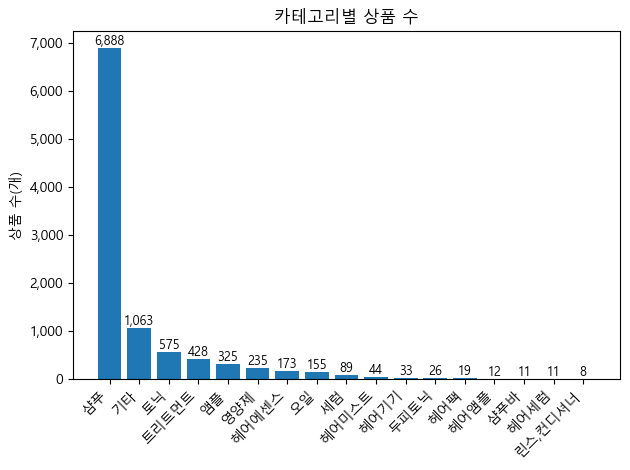

C:\Users\kbjoo\AppData\Local\Temp\ipykernel_46128\2206792660.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=cats, showfliers=False)


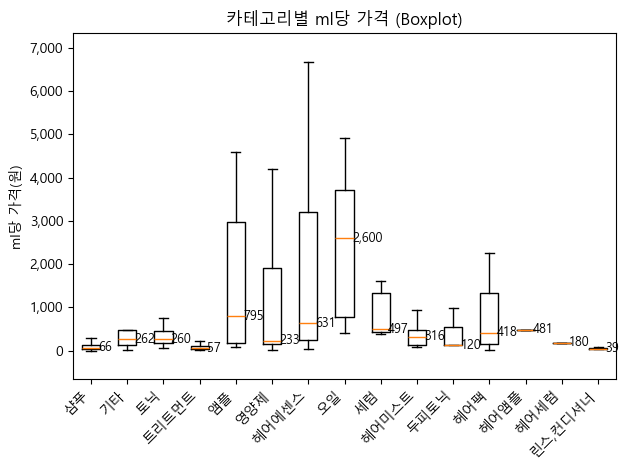

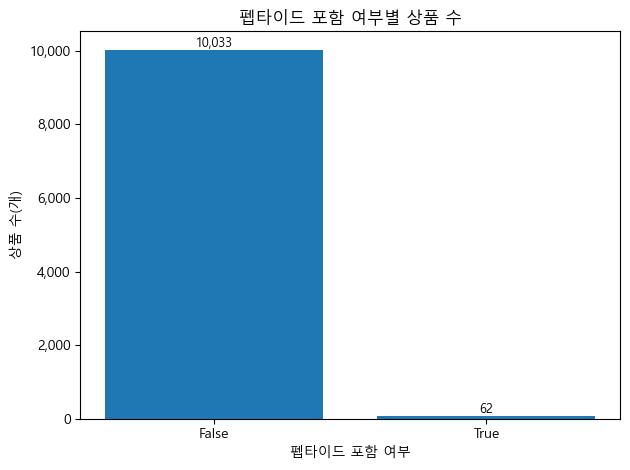

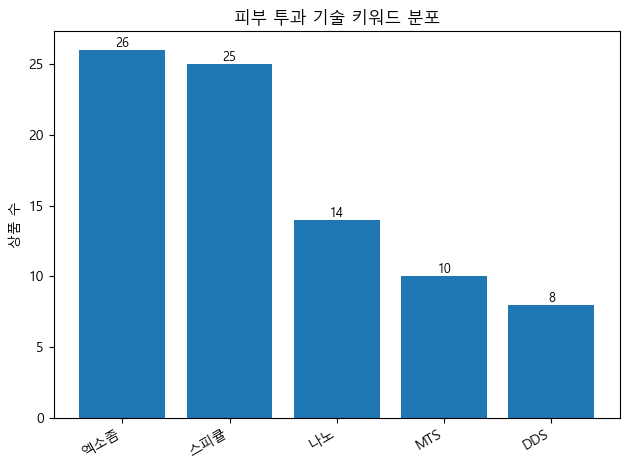

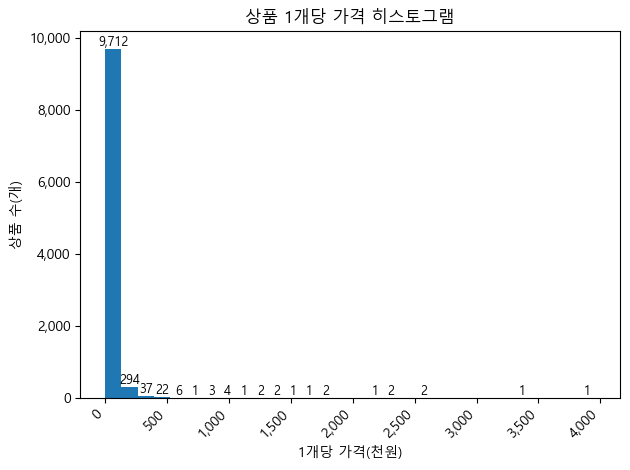

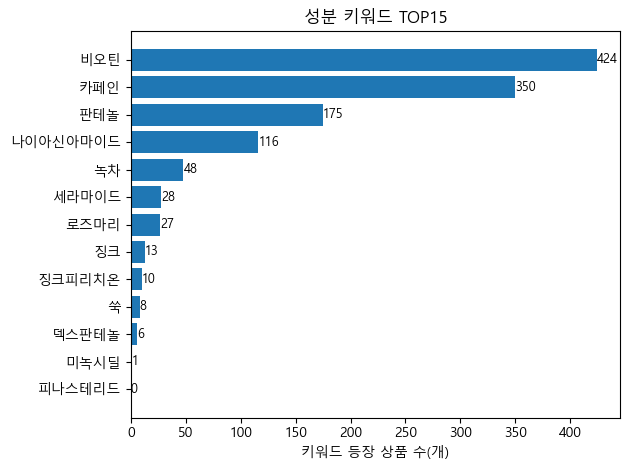

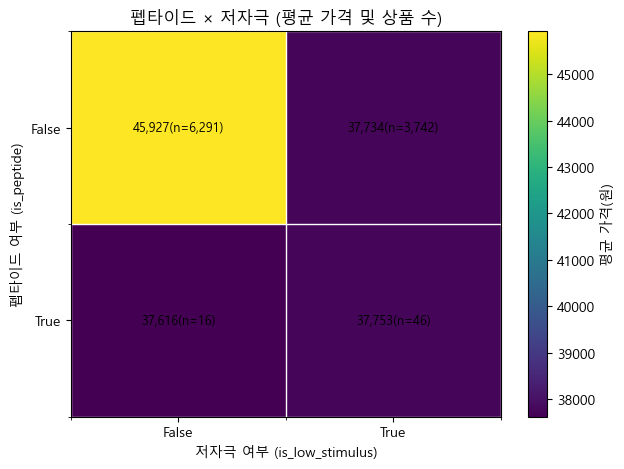

[WindowsPath('out_20251024_134022/chart_category_count_bar.png'),
 WindowsPath('out_20251024_134022/chart_price_per_ml_box.png'),
 WindowsPath('out_20251024_134022/chart_peptide_counts.png'),
 WindowsPath('out_20251024_134022/chart_skin_penetration_keywords.png'),
 WindowsPath('out_20251024_134022/chart_price_per_unit_hist.png'),
 WindowsPath('out_20251024_134022/chart_ingredients_top15.png'),
 WindowsPath('out_20251024_134022/chart_whitespace_matrix.png')]

In [378]:
charts = []
ret = save_category_bar(df, OUTDIR, show=True)
if ret is not None:
    path_bar, category_order = ret
    charts.append(path_bar)
else:
    category_order = None  # bar 차트가 없으면 순서 미고정(fallback 사용)
charts.append( save_price_per_ml_box(df, OUTDIR, show=True, category_order=category_order) )

charts.append(save_peptide_counts_bar(df, OUTDIR, show=True))
charts.append(save_skin_penetration_chart(df, OUTDIR, show=True))

charts.append(save_price_hist(df, OUTDIR, show=True))

charts.append(save_ingredient_bar(df, CFG, OUTDIR, show=True))
charts.append(save_whitespace_matrix(df, OUTDIR, show=True))

charts

### 보고서

In [379]:
report_md = write_markdown_report(OUTDIR, kpis, charts, df)
report_md

WindowsPath('out_20251024_134022/report.md')